In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, mean_squared_error, mean_absolute_error
plt.rcParams["font.family"] = "serif"
plt.rcParams["pdf.fonttype"] = 42
import os

In [2]:
df_original = pd.read_csv("../data/diabetes.csv")
df_original.shape
df_original.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# Since we are interested in classifiying those whom are diabetic, we will use the "Outcome" as our target variable.

In [3]:
df_diabetics = df_original[df_original['Outcome'] == 1]
df_non_diabetics = df_original[df_original['Outcome'] == 0]

In [4]:
print(df_diabetics.shape)
print(df_non_diabetics.shape)

(268, 9)
(500, 9)


In [5]:
# Convert target variable to binary variable
threshold = 0.5 # Define a threshold value for the target variable
df_original["Outcome"] = df_original["Outcome"].apply(lambda x: 1 if x >= threshold else 0)

In [6]:
Y = df_original['Outcome']
X = df_original.drop('Outcome', axis=1)

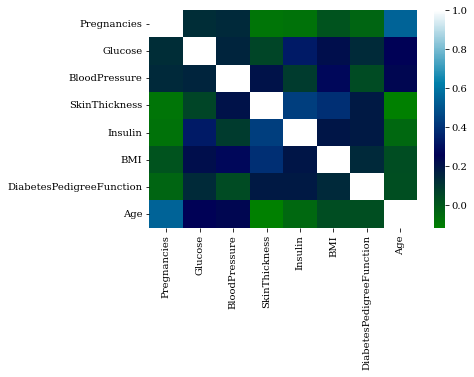

In [7]:
cor_matrix = X.corr()
sns.heatmap(cor_matrix, annot=False, cmap = "ocean");

## Split the data into training, validation, and testing datasets.

In the following cell, we will follow the methodology used from David Landup in https://stackabuse.com/scikit-learns-traintestsplit-training-testing-and-validation-sets/. 

"To split the data proportionally into a training, testing and validation set - we need to set the $test$ argument to"
$$
test = \frac{validation}{train+test}.
$$

This will allow for the creation of the $train$, $validation$, and $test$ dataset to be seperated into specified sizes.

In [8]:
# Split the data into train, validation, and test sets
train_ratio = 0.70
test_ratio = 0.15
validation_ratio = 0.15

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_ratio, random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=validation_ratio/(train_ratio+test_ratio), random_state=42)

## Now we need to scale the X_train, X_validation, and X_test datasets.

In [9]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the dataframe to perform min-max scaling
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_valid = pd.DataFrame(scaler.fit_transform(X_valid), columns=X_valid.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

In [10]:
X_train.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000
mean,0.226844,0.612035,0.611237,0.326048,0.098210,0.540115,0.169015,0.196735
std,0.197254,0.162224,0.156156,0.248179,0.140161,0.130221,0.147824,0.189606
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.058824,0.505051,0.561404,0.000000,0.000000,0.455808,0.068522,0.050000
50%,0.176471,0.590909,0.631579,0.365079,0.052009,0.538721,0.127837,0.133333
75%,0.352941,0.707071,0.701754,0.523810,0.153664,0.616162,0.236724,0.316667
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Decision Tree Classifier.

In [11]:
dt_model = DecisionTreeClassifier()
param_grid = {
    "criterion": ["gini", "entropy"],
    'max_depth': [5, 10, 15],
    'max_features':["sqrt", "log2", None]
}

grid_search_dt = GridSearchCV(dt_model, param_grid, cv=5)
# fit the grid search object to the training data
grid_search_dt.fit(X_train, Y_train)

# get the best hyperparameters
best_params_dt = grid_search_dt.best_params_

# create a new random forest regressor with the best hyperparameters
dt_model = DecisionTreeClassifier(max_depth=best_params_dt['max_depth'], criterion=best_params_dt["criterion"], max_features=best_params_dt['max_features'])

# fit the model to the training data
dt_model.fit(X_train, Y_train)

# generate predictions on the training data
dt_train_pred = dt_model.predict(X_train)

# evaluate the model on the validation data
dt_valid_pred = dt_model.predict(X_valid)

# generate predictions on the testing data
dt_test_pred = dt_model.predict(X_test)

rmse_dt_valid = mean_squared_error(Y_valid, dt_valid_pred, squared=False)
mae_dt_valid = mean_absolute_error(Y_valid, dt_valid_pred)
rmse_dt_test = mean_squared_error(Y_test, dt_test_pred, squared=False)
mae_dt_test= mean_absolute_error(Y_test, dt_test_pred)

accuracy_dt_valid = accuracy_score(Y_valid, dt_valid_pred)
accuracy_dt_test = accuracy_score(Y_test, dt_test_pred)

print("Best Hyperparameters: ", best_params_dt)
print("\nValidation's RMSE: {:.3f}".format(rmse_dt_valid))
print("Validation's MAE: {:.3f}".format(mae_dt_valid))
print("Validation's Acc: {:.3f}\n".format(accuracy_dt_valid))

print("Test's RMSE: {:.3f}".format(rmse_dt_test))
print("Test's MAE: {:.3f}".format(mae_dt_test))
print("Test's Acc: {:.3f}".format(accuracy_dt_test))


Best Hyperparameters:  {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2'}

Validation's RMSE: 0.517
Validation's MAE: 0.267
Validation's Acc: 0.733

Test's RMSE: 0.473
Test's MAE: 0.224
Test's Acc: 0.776


## Random Forest Classifier.

In [12]:
rf_model = RandomForestClassifier()
param_grid_rf = {
    "criterion": ["gini", "entropy"],
    'n_estimators': [100, 500, 1000],
    'max_depth': [5, 10, 15]
}

grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5)
# fit the grid search object to the training data
grid_search_rf.fit(X_train, Y_train)

# get the best hyperparameters
best_params_rf = grid_search_rf.best_params_

# create a new random forest regressor with the best hyperparameters
rf_model = RandomForestClassifier(n_estimators=best_params_rf['n_estimators'], max_depth=best_params_rf['max_depth'], criterion=best_params_rf["criterion"])

# fit the model to the training data
rf_model.fit(X_train, Y_train)

# generate predictions on the training data
rf_train_pred = rf_model.predict(X_train)

# evaluate the model on the validation data
rf_valid_pred = rf_model.predict(X_valid)

# generate predictions on the testing data
rf_test_pred = rf_model.predict(X_test)

rmse_rf_valid = mean_squared_error(Y_valid, rf_valid_pred, squared=False)
mae_rf_valid = mean_absolute_error(Y_valid, rf_valid_pred)
rmse_rf_test = mean_squared_error(Y_test, rf_test_pred, squared=False)
mae_rf_test= mean_absolute_error(Y_test, rf_test_pred)

accuracy_rf_valid = accuracy_score(Y_valid, rf_valid_pred)
accuracy_rf_test = accuracy_score(Y_test, rf_test_pred)

print("Best Hyperparameters: ", best_params_rf)
print("\nValidation's RMSE: {:.3f}".format(rmse_rf_valid))
print("Validation's MAE: {:.3f}".format(mae_rf_valid))
print("Validation's Acc: {:.3f}\n".format(accuracy_rf_valid))

print("Test's RMSE: {:.3f}".format(rmse_rf_test))
print("Test's MAE: {:.3f}".format(mae_rf_test))
print("Test's Acc: {:.3f}".format(accuracy_rf_test))

Best Hyperparameters:  {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 100}

Validation's RMSE: 0.525
Validation's MAE: 0.276
Validation's Acc: 0.724

Test's RMSE: 0.473
Test's MAE: 0.224
Test's Acc: 0.776


# eXtreme Gradient Boosting (XGB) modeling.

In [13]:
# Define the XGBoost model
xgb_model = xgb.XGBClassifier()

# Define the hyperparameter grid
param_grid_xgb = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 9],
    'colsample_bytree': [0.5, 0.7, 1.0],
}

# Perform grid search
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    cv=5
)

grid_search_xgb.fit(X_train, Y_train, verbose=False)

# Get the best hyperparameters
best_params_xgb = grid_search_xgb.best_params_

# Create a new XGBoost model with the best hyperparameters
xgb_model = xgb.XGBClassifier(
    n_estimators=best_params_xgb['n_estimators'],
    learning_rate=best_params_xgb['learning_rate'],
    max_depth=best_params_xgb['max_depth'],
    colsample_bytree=best_params_xgb['colsample_bytree']
)

# Fit the model with the best hyperparameters on the training data
xgb_model.fit(X_train, Y_train, verbose=False)

# Generate predictions on the training data
xgb_train_pred = xgb_model.predict(X_train)

# Generate predictions on the validation data
xgb_valid_pred = xgb_model.predict(X_valid)

# generate predictions on the testing data
xgb_test_pred = xgb_model.predict(X_test)

# Evaluate the model on the validation data
rmse_xgb_valid = mean_squared_error(Y_valid, xgb_valid_pred, squared=False)
mae_xgb_valid = mean_absolute_error(Y_valid, xgb_valid_pred)

# Evaluate the model on the testing data
rmse_xgb_test = mean_squared_error(Y_test, xgb_test_pred, squared=False)
mae_xgb_test= mean_absolute_error(Y_test, xgb_test_pred)

accuracy_xgb_valid = accuracy_score(Y_valid, xgb_valid_pred)
accuracy_xgb_test = accuracy_score(Y_test, xgb_test_pred)

# Print the results
print("Best Hyperparameters: ", best_params_xgb)
print("\nValidation's RMSE: {:.3f}".format(rmse_xgb_valid))
print("Validation's MAE: {:.3f}".format(mae_xgb_valid))
print("Validation's Acc: {:.3f}\n".format(accuracy_xgb_valid))

print("Test's RMSE: {:.3f}".format(rmse_xgb_test))
print("Test's MAE: {:.3f}".format(mae_xgb_test))
print("Test's Acc: {:.3f}\n".format(accuracy_xgb_test))

Best Hyperparameters:  {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 1000}

Validation's RMSE: 0.500
Validation's MAE: 0.250
Validation's Acc: 0.750

Test's RMSE: 0.500
Test's MAE: 0.250
Test's Acc: 0.750



## Neural Network Classifier.

In [14]:
# Define the MLPClassifier model
NN_model = MLPClassifier()

# Define the hyperparameter grid
param_grid_NN = {
    'hidden_layer_sizes': [(64, 32, 16, 8, 4, 2), (32, 16, 8, 4, 2), (64, 32, 16, 4, 2),(256, 128, 64, 32, 16, 8, 4, 2)],
    'max_iter': [1000, 2000, 3000],
    'alpha': [0.1, 0.01, 0.001],
    'activation': ['tanh', 'logistic', 'relu']
}

# Perform grid search
grid_search_NN = GridSearchCV(
    estimator=NN_model,
    param_grid=param_grid_NN,
    cv=5
)

grid_search_NN.fit(X_train, Y_train)

# Get the best hyperparameters
best_params_NN = grid_search_NN.best_params_

# Create a new MLPClassifier model with the best hyperparameters
NN_model = MLPClassifier(
    hidden_layer_sizes=best_params_NN['hidden_layer_sizes'],
    max_iter=best_params_NN['max_iter'],
    alpha=best_params_NN['alpha'],
    activation=best_params_NN['activation']
)

# Fit the model with the best hyperparameters on the training data
NN_model.fit(X_train, Y_train)

# Generate predictions on the training data
NN_train_pred = NN_model.predict(X_train)

# Generate predictions on the validation data
NN_valid_pred = NN_model.predict(X_valid)

# generate predictions on the testing data
NN_test_pred = NN_model.predict(X_test)

# Evaluate the model on the validation data
rmse_NN_valid = mean_squared_error(Y_valid, NN_valid_pred, squared=False)
mae_NN_valid = mean_absolute_error(Y_valid, NN_valid_pred)

# Evaluate the model on the testing data
rmse_NN_test = mean_squared_error(Y_test, NN_test_pred, squared=False)
mae_NN_test = mean_absolute_error(Y_test, NN_test_pred)

accuracy_NN_valid = accuracy_score(Y_valid, NN_valid_pred)
accuracy_NN_test = accuracy_score(Y_test, NN_test_pred)

# Print the results
print("Best Hyperparameters: ", best_params_NN)
print("\nValidation's RMSE: {:.3f}".format(rmse_NN_valid))
print("Validation's MAE: {:.3f}".format(mae_NN_valid))
print("Validation's Acc: {:.3f}\n".format(accuracy_NN_valid))

print("Test's RMSE: {:.3f}".format(rmse_NN_test))
print("Test's MAE: {:.3f}".format(mae_NN_test))
print("Test's Acc: {:.3f}\n".format(accuracy_NN_test))

Best Hyperparameters:  {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (32, 16, 8, 4, 2), 'max_iter': 1000}

Validation's RMSE: 0.491
Validation's MAE: 0.241
Validation's Acc: 0.759

Test's RMSE: 0.491
Test's MAE: 0.241
Test's Acc: 0.759



## Plot the RMSE and MAE values for the Validation and Testing dataset.

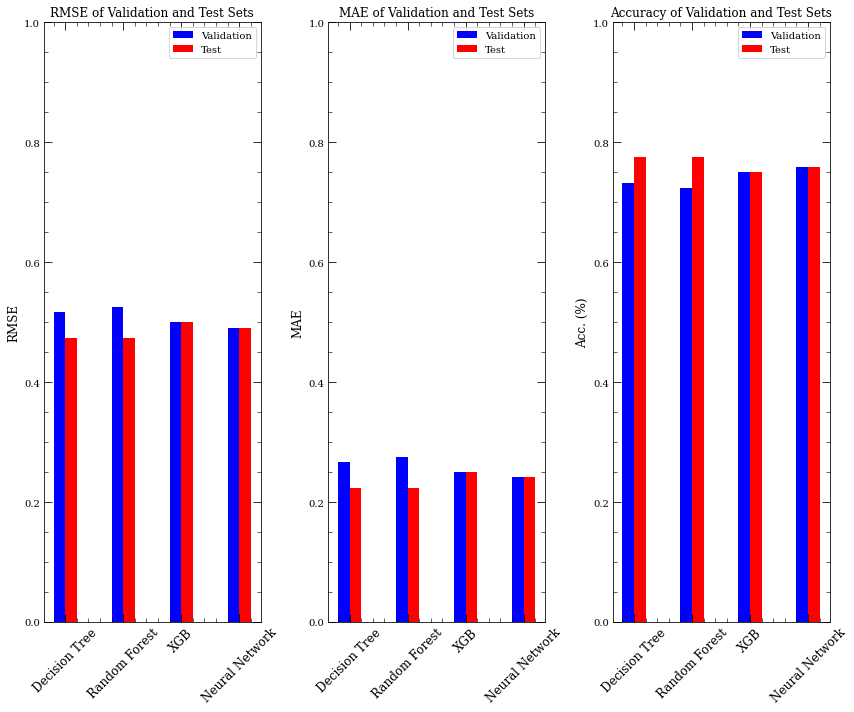

In [16]:
rmse_valid = [rmse_dt_valid, rmse_rf_valid, rmse_xgb_valid, rmse_NN_valid]
mae_valid = [mae_dt_valid, mae_rf_valid, mae_xgb_valid, mae_NN_valid]

rmse_test = [rmse_dt_test, rmse_rf_test, rmse_xgb_test, rmse_NN_test]
mae_test = [mae_dt_test, mae_rf_test, mae_xgb_test, mae_NN_test]

acc_valid = [accuracy_dt_valid, accuracy_rf_valid, accuracy_xgb_valid, accuracy_NN_valid]
acc_test = [accuracy_dt_test, accuracy_rf_test, accuracy_xgb_test, accuracy_NN_test]

model_labels = ['Decision Tree', 'Random Forest', 'XGB', 'Neural Network']

train_positions = np.arange(len(model_labels))
bar_width = 0.2  # Width of each bar

plt.figure(figsize=(12, 10))

ax1 = plt.subplot(1, 3, 1)
ax1.bar(train_positions - bar_width/2, rmse_valid, color='blue', width=bar_width, label='Validation')
ax1.bar(train_positions + bar_width/2, rmse_test, color='red', width=bar_width, label='Test')
ax1.set_title('RMSE of Validation and Test Sets', fontsize=12)
ax1.set_ylabel('RMSE', fontsize=12)
ax1.set_ylim(0, 1)
ax1.set_xticks(train_positions)
ax1.set_xticklabels(model_labels, fontsize=12, rotation=45)
ax1.legend(loc="best")
ax1.minorticks_on()
ax1.tick_params(top=True, right=True, which='both', direction='in', length=8)
ax1.tick_params(top=True, right=True, which='minor', direction='in', length=4)

ax2 = plt.subplot(1, 3, 2)
ax2.bar(train_positions - bar_width/2, mae_valid, color='blue', width=bar_width, label='Validation')
ax2.bar(train_positions + bar_width/2, mae_test, color='red', width=bar_width, label='Test')
ax2.set_title('MAE of Validation and Test Sets', fontsize=12)
ax2.set_ylabel('MAE', fontsize=12)
ax2.set_ylim(0, 1)
ax2.set_xticks(train_positions)
ax2.set_xticklabels(model_labels, fontsize=12, rotation=45)
ax2.legend(loc="best")
ax2.minorticks_on()
ax2.tick_params(top=True, right=True, which='both', direction='in', length=8)
ax2.tick_params(top=True, right=True, which='minor', direction='in', length=4)

ax3 = plt.subplot(1, 3, 3)
ax3.bar(train_positions - bar_width/2, acc_valid, color='blue', width=bar_width, label='Validation')
ax3.bar(train_positions + bar_width/2, acc_test, color='red', width=bar_width, label='Test')
ax3.set_title('Accuracy of Validation and Test Sets', fontsize=12)
ax3.set_ylabel('Acc. (%)', fontsize=12)
ax3.set_ylim(0, 1)
ax3.set_xticks(train_positions)
ax3.set_xticklabels(model_labels, fontsize=12, rotation=45)
ax3.legend(loc="best")
ax3.minorticks_on()
ax3.tick_params(top=True, right=True, which='both', direction='in', length=8)
ax3.tick_params(top=True, right=True, which='minor', direction='in', length=4)

plt.tight_layout()
plt.show()

# Pick the NN model.

In [17]:
Y_train_proba = NN_model.predict_proba(X_train)[:, 1] # Probability of positive class
Y_valid_proba = NN_model.predict_proba(X_valid)[:, 1] # Probability of positive class

# Calculate evaluation metrics for the validation dataset
accuracy = accuracy_score(Y_valid, NN_valid_pred)
precision = precision_score(Y_valid, NN_valid_pred, average="binary")
recall = recall_score(Y_valid, NN_valid_pred, average="binary")
f1 = f1_score(Y_valid, NN_valid_pred, average="binary")
train_auc = roc_auc_score(Y_train, Y_train_proba)
valid_auc = roc_auc_score(Y_valid, Y_valid_proba)
conf_matrix = confusion_matrix(Y_valid, NN_valid_pred)
cv_scores = cross_val_score(NN_model, X, Y, cv=5)
rmse = mean_squared_error(Y_valid, NN_valid_pred, squared=False) 
mae = mean_absolute_error(Y_valid, NN_valid_pred)

#Print the evaluation metrics
print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1-Score: {:.3f}".format(f1))
print("RMSE: {:.3f}".format(rmse))
print("MAE: {:.3f}".format(mae))
print("Train AUC: {:.3f}".format(train_auc))
print("Valid AUC: {:.3f}".format(valid_auc))
print('Mean CV score: {:.3f}'.format(cv_scores.mean()))
print("Confusion matrix:\n", conf_matrix)

Accuracy: 0.759
Precision: 0.815
Recall: 0.489
F1-Score: 0.611
RMSE: 0.491
MAE: 0.241
Train AUC: 0.864
Valid AUC: 0.860
Mean CV score: 0.658
Confusion matrix:
 [[66  5]
 [23 22]]


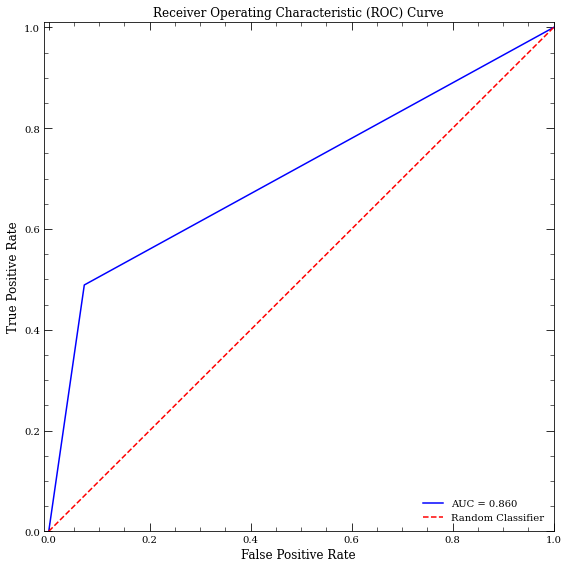

In [18]:
fig, ax = plt.subplots(figsize=(8, 8))
# Compute the false positive rate, true positive rate, and threshold values required for plotting the ROC curve
fpr, tpr, thresholds = roc_curve(Y_valid, NN_valid_pred)

# Plot the ROC curve
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(valid_auc), color="blue")
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier', color="red")
plt.xlabel('False Positive Rate', fontsize=12)

ax.minorticks_on()
ax.xaxis.set_ticks_position("both")
ax.tick_params(top=True, right=True, which='major', direction='in', length=8, labelbottom=True, labeltop=False)
ax.tick_params(top=True, right=True, which='minor', direction='in', length=4)
ax.set_ylim(0,1.01)
ax.set_xlim(-0.01,1)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=12)
plt.legend(loc="lower right", frameon=False)
fig.tight_layout()
plt.show();